In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import time
from keras.callbacks import EarlyStopping, ModelCheckpoint 
from keras.layers import Activation, BatchNormalization, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from pprint import pprint
from pylab import *
from sklearn.preprocessing import StandardScaler

import model_utils as util

sys.path.append('../')
import data_manipulations as manip

%matplotlib inline

plt.rcParams['figure.figsize'] = 10, 8
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
DATA_PATH =  '../../data/cluster/year/'
os.listdir(DATA_PATH)

['weights.bestNN.hdf5',
 'X_big_test.csv',
 'X_big_train.csv',
 'X_big_valid.csv',
 'X_test.csv',
 'X_train.csv',
 'X_valid.csv',
 'y_big_test.csv',
 'y_big_train.csv',
 'y_big_valid.csv',
 'y_test.csv',
 'y_train.csv',
 'y_valid.csv']

In [3]:
def load_data(data_dir):
    X_train = pd.read_csv(data_dir + 'X_big_train.csv')
    print('X_train:', X_train.shape)
    X_valid = pd.read_csv(data_dir + 'X_big_valid.csv')
    print('X_valid:', X_valid.shape)
    X_test  = pd.read_csv(data_dir + 'X_big_test.csv')
    print('X_test:',  X_test.shape)
    y_train = pd.read_csv(data_dir + 'y_big_train.csv')
    print('y_train:', y_train.shape)
    y_valid = pd.read_csv(data_dir + 'y_big_valid.csv')
    print('y_valid:', y_valid.shape)
    y_test  = pd.read_csv(data_dir + 'y_big_test.csv')
    print('y_test:',  y_test.shape)
    
    return [[X_train, y_train], [X_valid, y_valid], [X_test, y_test]]

In [4]:
[[X_train, y_train], 
 [X_valid, y_valid], 
 [X_test, y_test]] = load_data(DATA_PATH)

X_train: (529623, 428)
X_valid: (176541, 428)
X_test: (176541, 428)
y_train: (529623, 1)
y_valid: (176541, 1)
y_test: (176541, 1)


In [5]:
util.print_percent_presence(y_train, 'y_train')
util.print_percent_presence(y_valid, 'y_valid')
util.print_percent_presence(y_test,  'y_test')

Percent presence in y_train: 17.26%
Percent presence in y_valid: 13.92%
Percent presence in y_test: 12.64%


In [6]:
print('Baseline accuracy if predicting "absent" for all cells:')
print('  train:', 100 - 17.26)
print('  valid:', 100 - 13.92)
print('  test: ', 100 - 12.64)

Baseline accuracy if predicting "absent" for all cells:
  train: 82.74
  valid: 86.08
  test:  87.36


In [7]:
is_finite = np.isfinite(X_valid).all()
have_nans = list(is_finite[is_finite == False].index)
have_nans

['varPrecip_growingSeason',
 'meanTemp_Aug.varPrecip_growingSeason',
 'meanMaxTemp_Aug.varPrecip_growingSeason',
 'varPrecip_growingSeason.precip_OctSep_L10112864',
 'varPrecip_growingSeason.precipPrevious_OctSep_L1065',
 'varPrecip_growingSeason.precip_meanAnnual_L1049',
 'varPrecip_growingSeason.elev_etopo1_L111',
 'varPrecip_growingSeason.precip_growingSeason_L35',
 'vegetation.varPrecip_growingSeason',
 'varPrecip_growingSeason.meanTemp_Aug_L129',
 'varPrecip_growingSeason.meanTemp_Annual_L385',
 'varPrecip_growingSeason.meanMaxTemp_Aug_L495',
 'varPrecip_growingSeason.lon',
 'varPrecip_growingSeason.lat',
 'precip_JunAug.varPrecip_growingSeason',
 'varPrecip_growingSeason.meanMinTemp_DecFeb_L55',
 'precipPrevious_JunAug.varPrecip_growingSeason',
 'varPrecip_growingSeason.lat_L45',
 'year.varPrecip_growingSeason',
 'varPrecip_growingSeason.precipPrevious_JunAug_L6',
 'varPrecip_growingSeason.precip_JunAug_L10',
 'precip_growingSeason.varPrecip_growingSeason',
 'varPrecip_growingSea

In [8]:
X_train, y_train = util.drop_nans(
    X_train, y_train, 'varPrecip_growingSeason')
X_valid, y_valid = util.drop_nans(
    X_valid, y_valid, 'varPrecip_growingSeason')
X_test,  y_test  = util.drop_nans(
    X_test,  y_test,  'varPrecip_growingSeason')

(526849, 428) (526849, 1)
(176146, 428) (176146, 1)
(175416, 428) (175416, 1)


In [9]:
is_finite = np.isfinite(X_valid).all()
have_nans = list(is_finite[is_finite == False].index)
have_nans

[]

In [10]:
full_test = X_test.copy()
full_test['beetle'] = y_test['beetle']

In [12]:
# Drop 'studyArea' from predictors (all 1 in the reduced data) and 'x' and
# 'y' (perfectly correlated with 'lon' and 'lat')
X_train = X_train.drop(['x', 'y'], axis=1)
X_valid = X_valid.drop(['x', 'y'], axis=1)
X_test  = X_test.drop(['x',  'y'], axis=1)

In [13]:
# Normalize data to make gradient descent more efficient
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test  = scaler.transform(X_test)

In [14]:
y_train = util.vectorize(y_train.as_matrix())
y_valid = util.vectorize(y_valid.as_matrix())
y_test  = util.vectorize(y_test.as_matrix())

# Neural Net Model

In [15]:
best_val_loss = np.inf
X_train.shape

(526849, 426)

In [39]:
# Params and Hyperparams
n_inputs = X_train.shape[1]
n_outputs = 2

# Current best
N_LAYERS = 4
NODES_PER_LAYER = ([n_inputs] * N_LAYERS)
#NODES_PER_LAYER = [
    #n_inputs, n_inputs * 2]#, n_inputs * 4, n_inputs * 8, n_inputs * 8, 
    #n_inputs * 8, n_inputs * 8, n_inputs * 8, n_inputs * 4, n_inputs * 2, 
    #n_inputs]
NODES_PER_LAYER.append(n_outputs)
ETA = 0.5
DROPOUT = 0.7
BETA_1 = 0.9
BETA_2 = 0.999
EPSILON = 1e-08
DECAY = 0.01
EPOCHS = 30
BATCH_SIZE = 1024

NODES_PER_LAYER

[426, 426, 426, 426, 2]

In [40]:
def get_params():
    return {'NODES_PER_LAYER': NODES_PER_LAYER,
            'ETA': ETA,
            'DROPOUT': DROPOUT,
            'BETA_1': BETA_1,
            'BETA_2': BETA_2,
            'EPSILON': EPSILON,
            'DECAY': DECAY,
            'EPOCHS': EPOCHS,
            'BATCH_SIZE': BATCH_SIZE}

In [41]:
model = Sequential()

# NOTE: "glorot-normal" is the same thing as "Xavier" initialization
model.add(Dense(NODES_PER_LAYER[1], 
                input_dim=NODES_PER_LAYER[0], 
                kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))

# additional hidden layers here
for i in range(2, len(NODES_PER_LAYER) - 1):
    model.add(Dense(NODES_PER_LAYER[i], 
                    kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(DROPOUT))

model.add(Dense(NODES_PER_LAYER[-1], kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 426)               181902    
_________________________________________________________________
batch_normalization_20 (Batc (None, 426)               1704      
_________________________________________________________________
activation_20 (Activation)   (None, 426)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 426)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 426)               181902    
_________________________________________________________________
batch_normalization_21 (Batc (None, 426)               1704      
_________________________________________________________________
activation_21 (Activation)   (None, 426)               0         
__________

In [42]:
adam = Adam(
    lr=ETA, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON, decay=DECAY)
model.compile(
    loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [43]:
VERBOSE = 1
checkpointer = ModelCheckpoint(filepath=DATA_PATH + 'weights.bestNN.hdf5',
                               verbose=VERBOSE,
                               save_best_only=True)
earlyStop = EarlyStopping(monitor='val_loss', patience=EPOCHS / 2)
start = time.time()
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[checkpointer, earlyStop],
                    verbose=VERBOSE)
elapsed = time.time() - start
print('Time: %.2f minutes' % (elapsed / 60))

Train on 526849 samples, validate on 176146 samples
Epoch 1/30
526849/526849 [==============================] - 120s 228us/step - loss: 0.3073 - acc: 0.8579 - val_loss: 13.7943 - val_acc: 0.1395
Epoch 2/30
526849/526849 [==============================] - 118s 224us/step - loss: 0.2662 - acc: 0.8774 - val_loss: 13.7943 - val_acc: 0.1395
Epoch 3/30
526849/526849 [==============================] - 119s 225us/step - loss: 0.2580 - acc: 0.8821 - val_loss: 13.7943 - val_acc: 0.1395
Epoch 4/30
526849/526849 [==============================] - 118s 224us/step - loss: 0.2525 - acc: 0.8841 - val_loss: 9.7100 - val_acc: 0.2372
Epoch 5/30
526849/526849 [==============================] - 119s 226us/step - loss: 0.2484 - acc: 0.8855 - val_loss: 4.7581 - val_acc: 0.5698
Epoch 6/30
526849/526849 [==============================] - 119s 225us/step - loss: 0.2456 - acc: 0.8870 - val_loss: 2.2354 - val_acc: 0.8605
Epoch 7/30
526849/526849 [==============================] - 120s 227us/step - loss: 0.2432 - 

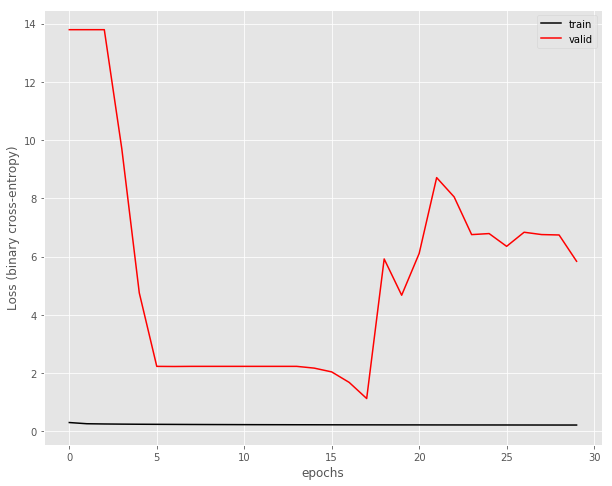

In [44]:
plt.plot(history.history['loss'], 'k-', label='train');
plt.plot(history.history['val_loss'], 'r-', label='valid');
plt.xlabel('epochs');
plt.ylabel('Loss (binary cross-entropy)')
#plt.yscale('log');
plt.legend(loc='best');

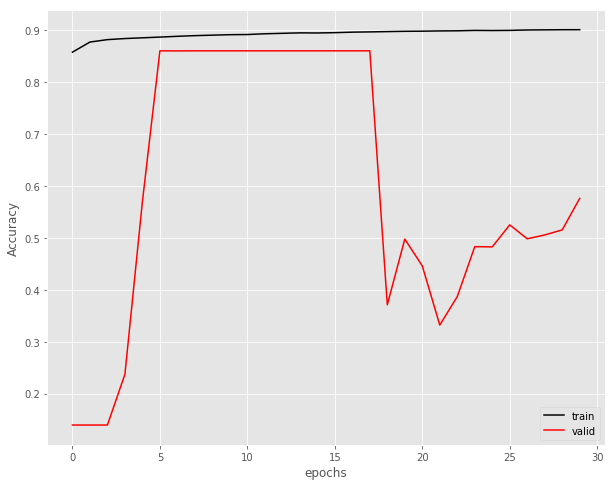

In [45]:
plt.plot(history.history['acc'], 'k-', label='train');
plt.plot(history.history['val_acc'], 'r-', label='valid');
plt.xlabel('epochs');
plt.ylabel('Accuracy')
#plt.yscale('log');
plt.legend(loc='best');

In [46]:
this_run = np.mean(history.history['val_loss'][-50:])
print('This run: %.5f' % this_run)

if this_run < best_val_loss:
    print('New Best Model Found!\n')
    best_val_loss = this_run
    train_loss_of_best = np.mean(history.history['loss'][-50:])
    best_params = get_params()
print('Best validation loss so far: %.5f' % best_val_loss)
print('Training loss of same model: %.5f' % train_loss_of_best)
print('Best hyperparameters found so far:')
pprint(best_params)

This run: 5.41958
New Best Model Found!

Best validation loss so far: 5.41958
Training loss of same model: 0.23581
Best hyperparameters found so far:
{'BATCH_SIZE': 1024,
 'BETA_1': 0.9,
 'BETA_2': 0.999,
 'DECAY': 0.01,
 'DROPOUT': 0.7,
 'EPOCHS': 30,
 'EPSILON': 1e-08,
 'ETA': 0.5,
 'NODES_PER_LAYER': [426, 426, 426, 426, 2]}


In [47]:
preds = model.predict(X_test)
pred_probs = util.preds2probs(preds)
preds = util.one_cold(util.binarize(preds))
y_test_cold = util.one_cold((y_test))
cm = util.make_confusion_matrix(y_test_cold, pred_probs, 0.5)

Confusion Matrix:
         Predicted:
         	1		0
Actual: 1	0		22314
        0	0		153102


In [48]:
metrics = util.get_metrics(cm)

Accuracy:  0.872793815843
Precision: nan
Recall:    0.0
F1:        nan


/Users/dsp/dongmei/sdm/python/models/model_utils.py:110: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm['tp'] / (cm['tp'] + cm['fp'])


In [49]:
auc_metrics = util.get_auc(y_test_cold, pred_probs)

AUC:       0.499996734203


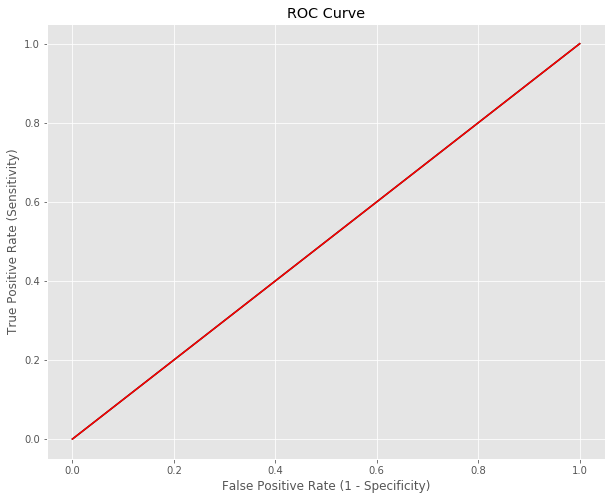

In [50]:
util.plot_roc(auc_metrics['fpr'], auc_metrics['tpr'])

In [51]:
def column2matrix(dataframe, column, cell_dim=10000):
    '''                                                                          
    Convert a column from DataFrame df into a matrix representation with the     
    upper-left cell indexing beginning at [0, 0].                                
    It is expected that the DataFrame has columns x and y.                       
                                                                                 
    Args:                                                                        
    df: DataFrame: the source data                                               
    column: string: the column name to extract                                   
    cel_dim: numeric: the dimensions of each grid cell                           
                                                                                 
    Returns: np.ndarray (a 2D list; matrix)                                      
    '''
    df = dataframe.copy()
    x_min = df.x.min()
    y_min = df.y.min()
    df.x -= x_min
    df.y -= y_min
    xs = sorted(df.x.unique())
    ys = sorted(df.y.unique())
    matrix = np.array([[np.nan for y in range(len(ys))]
                       for x in range(len(xs))])

    for row in df.index:
        x, y, value = df.loc[row, ['x', 'y', column]]
        i = int((x - xs[0]) / cell_dim)
        j = int((y - ys[0]) / cell_dim)
        matrix[i, j] = value

    return matrix

In [52]:
test_2000 = full_test.loc[full_test.year == 2000, :]
test_2001 = full_test.loc[full_test.year == 2001, :]
test_2002 = full_test.loc[full_test.year == 2002, :]
test_2000.head()

,year,meanTemp_Annual,meanTemp_AprAug,meanTemp_Aug,meanMinTemp_DecFeb,meanMinTemp_Oct,meanMinTemp_Jan,meanMinTemp_Mar,meanMaxTemp_Aug,precip_meanAnnual,...,precip_OctSep.lat_L45,precip_OctSep.precip_growingSeason_L35,precip_OctSep.precipPrevious_OctSep_L1065,precip_OctSep.precip_meanAnnual_L1049,precip_OctSep.precip_OctSep_L10112864,meanMaxTemp_Aug.precip_OctSep,meanTemp_AprAug.precip_OctSep,precip_OctSep.varPrecip_growingSeason,meanTemp_Aug.precip_OctSep,beetle
1,2000,17.254652,19.109267,21.808772,5.056313,11.052817,6.231007,7.827016,27.346988,6.621443,...,110.904391,110.904391,0.0,0.0,0.0,3032.901079,2119.301565,87.706257,2418.688598,0
2,2000,17.676624,19.746520,22.608925,4.883052,11.081191,6.041158,7.776271,28.596847,6.506222,...,103.984019,103.984019,0.0,0.0,0.0,2973.615041,2053.322479,180.105604,2350.966874,0
3,2000,16.558509,18.864768,22.112176,3.356400,9.556494,4.649940,6.029264,28.749263,9.937936,...,197.437307,0.000000,0.0,0.0,0.0,5676.177043,3724.608934,33.989244,4365.768436,0
4,2000,16.781979,19.328211,22.731819,3.201135,9.459611,4.256498,5.852778,29.813080,9.939182,...,194.982168,0.000000,0.0,0.0,0.0,5813.019043,3768.656495,71.096740,4432.299443,0
5,2000,15.364015,18.031978,21.651566,1.695748,7.912659,3.012935,4.226322,29.026302,16.397472,...,350.616022,0.000000,0.0,0.0,0.0,10177.086564,6322.300275,55.819223,7591.385988,0


In [53]:
beetle_2000_matrix = column2matrix(test_2000, 'beetle')

In [54]:
pred_2000_matrix = column2matrix(test_2000, 'preds')
error_matrix = pred_2000_matrix - beetle_2000_matrix

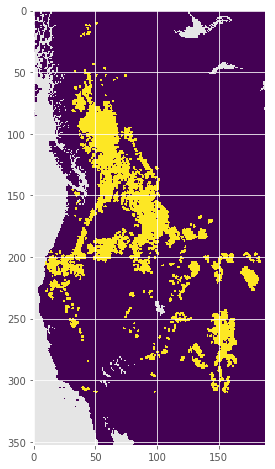

In [55]:
imshow(np.rot90(beetle_2000_matrix));

/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:823: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/usr/local/lib/python3.6/site-packages/numpy/ma/core.py:2766: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


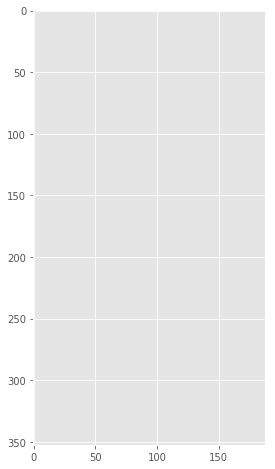

In [56]:
imshow(np.rot90(pred_2000_matrix));

/usr/local/lib/python3.6/site-packages/matplotlib/colors.py:823: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/usr/local/lib/python3.6/site-packages/numpy/ma/core.py:2766: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


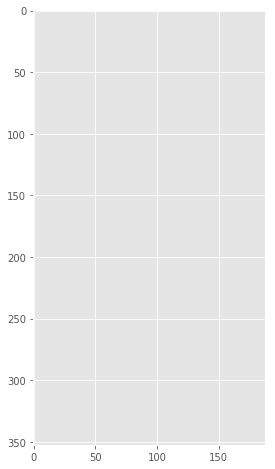

In [57]:
imshow(np.rot90(error_matrix));